In [81]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from scipy.signal import find_peaks


20000.0


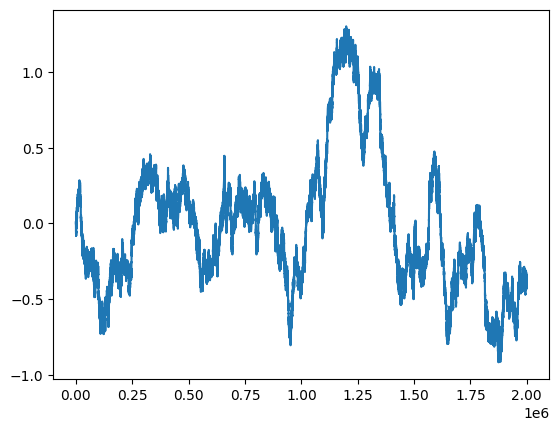

In [82]:
sampling_rate=2*1e6
sample_time=1/sampling_rate
N=2000000
def ou_noise(n, dt=1.0, mu=0.0, tau=20.0, sigma=1.0, x0=0.0, rng=None):
    rng = np.random.default_rng(rng)
    x = np.empty(n)
    x[0] = x0
    a = np.exp(-dt / tau)
    sd = sigma * np.sqrt(1 - a*a)
    for t in range(1, n):
        x[t] = mu + a*(x[t-1] - mu) + sd * rng.normal()
    return x
#I am setting tau to be 50ms
x = ou_noise(N, dt=sample_time, tau=100*1e-3, sigma=0.5)
plt.plot(x)
print(10*1e-3/sample_time)

In [83]:
Channel_dict={}
num_channels=10
actual_coh_time={}
for i in range(10):
    tau_I=random.randint(1,25)
    tau_Q=random.randint(1,25)
    Channel_dict[i]={'I':ou_noise(N,dt=sample_time,tau=tau_I*1e-3,sigma=0.5),'Q':ou_noise(N,dt=sample_time,tau=tau_Q*1e-3,sigma=0.5)}
    actual_coh_time[i]={'I':tau_I*1e-3/sample_time,'Q':tau_Q*1e-3/sample_time}
print(actual_coh_time)

{0: {'I': 22000.0, 'Q': 26000.000000000004}, 1: {'I': 42000.00000000001, 'Q': 16000.000000000002}, 2: {'I': 44000.0, 'Q': 44000.0}, 3: {'I': 8000.000000000001, 'Q': 24000.0}, 4: {'I': 50000.00000000001, 'Q': 40000.0}, 5: {'I': 40000.0, 'Q': 12000.0}, 6: {'I': 30000.0, 'Q': 38000.0}, 7: {'I': 38000.0, 'Q': 20000.0}, 8: {'I': 28000.000000000004, 'Q': 44000.0}, 9: {'I': 12000.0, 'Q': 20000.0}}


In [84]:
from numpy.fft import rfft, irfft

def autocorr_fft(x):
    x = np.asarray(x)
    x = x - x.mean()            # optional, improves robustness
    n = len(x)
    nfft = 1 << (2*n-1).bit_length()  # next pow2 for speed
    X = rfft(x, nfft)
    r = irfft(X * np.conj(X), nfft)[:n]   # non-negative lags
    r = r / (r[0] + 1e-20)      # normalize
    return r

def find_coh_time_fft(x, threshold=1e-2):
    r = autocorr_fft(x)
    # first lag where it drops below threshold
    idx = np.argmax(r <= threshold)  # returns 0 if first element meets
    if r[0] <= threshold:            # guard unlikely case
        return 0
    if idx == 0:                     # no drop found
        return len(r)                # cap at window length
    return idx

def find_coherence_time_per_channel(Wifi_symbol_dict):
    num_samples_per_coherence_detection=int(50*1e-3/sample_time) #We need 50ms data for this
    t_coh_dict={}
    for channel in Wifi_symbol_dict:
        t_coh_dict[channel]={'I':0,'Q':0}
        i=0
        number_samples=len(Wifi_symbol_dict[channel]['I'])
        t_coh_distribution_arr_I=[]
        t_coh_distribution_arr_Q=[]
        while num_samples_per_coherence_detection*i<number_samples:
            #normalised_I_samples=Wifi_symbol_dict[channel]['I']
            I_curr_samples=Wifi_symbol_dict[channel]['I'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
            Q_curr_samples=Wifi_symbol_dict[channel]['Q'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
            t_coh_distribution_arr_I.append(find_coh_time_fft(I_curr_samples))
            t_coh_distribution_arr_Q.append(find_coh_time_fft(Q_curr_samples))
            i+=1
            #print(i)
         #break
        t_coh_dict[channel]['I']=np.mean(t_coh_distribution_arr_I)
        t_coh_dict[channel]['Q']=np.mean(t_coh_distribution_arr_Q)
    
    return t_coh_dict


# #print(find_coh_time_fft(x[:100000]))
print(find_coherence_time_per_channel(Channel_dict))
dict_coherence_times = find_coherence_time_per_channel(Channel_dict)


{0: {'I': 20972.5, 'Q': 18113.75}, 1: {'I': 17944.9, 'Q': 17240.5}, 2: {'I': 23192.25, 'Q': 21865.15}, 3: {'I': 14486.1, 'Q': 20256.35}, 4: {'I': 22265.0, 'Q': 22882.55}, 5: {'I': 22665.0, 'Q': 15644.5}, 6: {'I': 20378.35, 'Q': 20203.95}, 7: {'I': 20569.0, 'Q': 18384.65}, 8: {'I': 18968.3, 'Q': 21521.4}, 9: {'I': 13318.7, 'Q': 20741.05}}


In [85]:
print(Channel_dict)

{0: {'I': array([ 0.        ,  0.00710754,  0.00720754, ..., -0.64626101,
       -0.64705004, -0.64650829]), 'Q': array([ 0.00000000e+00, -3.23506544e-03,  1.02104767e-03, ...,
       -1.07368779e+00, -1.07195889e+00, -1.07236296e+00])}, 1: {'I': array([ 0.00000000e+00, -6.96077473e-05, -3.38720555e-03, ...,
        1.47506077e-01,  1.45151089e-01,  1.43957901e-01]), 'Q': array([ 0.        , -0.00072395,  0.00308951, ...,  0.09741575,
        0.09963433,  0.09959365])}, 2: {'I': array([ 0.        , -0.00055566, -0.00611592, ..., -0.10179563,
       -0.09935373, -0.10880219]), 'Q': array([ 0.        , -0.0013612 , -0.00089197, ..., -0.47854516,
       -0.47895151, -0.48029119])}, 3: {'I': array([ 0.        , -0.00843241, -0.01764466, ..., -0.51111069,
       -0.49554758, -0.471068  ]), 'Q': array([ 0.        ,  0.0014524 ,  0.00240566, ..., -0.87255963,
       -0.87190053, -0.86959067])}, 4: {'I': array([ 0.        , -0.00210778,  0.00063232, ...,  0.26893611,
        0.27066055,  0.268

In [86]:
# multi armed bandit to select next channel to scan
int(50*1e-3/sample_time)

100000

In [101]:
# each channel is one arm
num_channels = 10 # number of arms

arm_coherent_time = {}
arm_dwell_time = {}

arms_with_reward = {}
arm_last_played_time = {}
arm_coherent_time = {}

for i in range(num_channels):
    arms_with_reward[i] = 0
    arm_last_played_time[i] = 0
    arm_coherent_time[i] = min(dict_coherence_times[i]['I'], dict_coherence_times[i]['Q'])
    #arm_coherent_time[i] = random.randint(400, 1000)
    arm_dwell_time[i] = int(1e8 / arm_coherent_time[i]) # seems correct


In [88]:
# print(Channel_dict)
# print(len(Channel_dict))
# print(Channel_dict[9])
# print(len(Channel_dict[9]['I']))
# print(arm_coherent_time[1])

In [102]:
def get_reward(channel_chosen, current_sample_index, arm_last_played_time, arm_coherent_time):
    reward = (current_sample_index - arm_last_played_time[channel_chosen])/arm_coherent_time[channel_chosen]
    return (reward)

In [103]:
def selected_arm(epsilon):
    k = random.random()
    if (k < epsilon) : 
        next_arm = random.randint(0, num_channels-1)
    else:
        next_arm = max(arms_with_reward, key = arms_with_reward.get)
    return(next_arm)

# def selected_arm():
#     next_arm = max(arms_with_reward, key = arms_with_reward.get)
#     return(next_arm)

In [104]:
Wifi_output_samples={}
temp_output_samples = {}
for channel in Channel_dict:
    Wifi_output_samples[channel]={'I':[],'Q':[]}  # storing in the form of a list of elements (sample_num,value) for I and Q
epsilon = 0.5
# epsilon_decay = 0.995
total_samples = 2000000

current_sample_index = 0
while(current_sample_index<total_samples):

    temp_output_samples = {}

    for i in range(num_channels):
        arms_with_reward[i] = get_reward(i, current_sample_index, arm_last_played_time, arm_coherent_time)
    next_arm = selected_arm(epsilon)
    temp_output_samples[next_arm] = {}
    temp_output_samples[next_arm]['I'] = []
    temp_output_samples[next_arm]['Q'] = []
    arms_with_reward[next_arm] = 0
    for i in range(arm_dwell_time[next_arm]):
        if current_sample_index==total_samples-1:
            current_sample_index+=1
            break
        Wifi_output_samples[next_arm]['I'].append([current_sample_index, Channel_dict[next_arm]['I'][current_sample_index]])
        Wifi_output_samples[next_arm]['Q'].append([current_sample_index, Channel_dict[next_arm]['Q'][current_sample_index]])
        temp_output_samples[next_arm]['I'].append(Channel_dict[next_arm]['I'][current_sample_index])
        temp_output_samples[next_arm]['Q'].append(Channel_dict[next_arm]['Q'][current_sample_index])
        current_sample_index+=1   

    # print(temp_output_samples)

    coh_time_to_update = find_coherence_time_per_channel(temp_output_samples)
    arm_coherent_time[next_arm] = min(coh_time_to_update[next_arm]['I'], coh_time_to_update[next_arm]['Q'])
    arm_dwell_time[next_arm] = int(1e8 / arm_coherent_time[next_arm]) # seems correct


    arm_last_played_time[next_arm] = current_sample_index

In [105]:
#print(arm_stddev)
#print(arm_mean_time)
for i in range(num_channels):
    print(Wifi_output_samples[i]['I'][:100])

[[0, 0.0], [1, 0.007107544630356927], [2, 0.007207539657759836], [3, 0.006921522262211111], [4, 0.0030247933844840414], [5, 0.002945196683544696], [6, 0.0007147735688856688], [7, 0.0012490384721896778], [8, 0.0013390382431323641], [9, -0.003670955534087982], [10, -0.0016876180170047983], [11, -0.0050930142652994715], [12, -0.00467035127454963], [13, 0.0013681951883029245], [14, -0.0016548956855313112], [15, -0.003300867038219838], [16, 0.0014839224896240522], [17, 0.0012358766426665874], [18, 0.002292588328796687], [19, 0.002637805339282852], [20, -0.0025856892634935316], [21, -0.007816569877067813], [22, -0.007871316046892906], [23, -0.009801205649558912], [24, -0.010750830176447105], [25, -0.01622721727910501], [26, -0.021479146219666536], [27, -0.01790324404708454], [28, -0.024633526649041594], [29, -0.02703709413557487], [30, -0.02136848543789592], [31, -0.029445661376457405], [32, -0.030283403109360205], [33, -0.042905042978933314], [34, -0.040742156432925024], [35, -0.04244337095

In [106]:
print(arm_last_played_time)

{0: 956474, 1: 1563166, 2: 724636, 3: 591481, 4: 1984233, 5: 2000000, 6: 1736471, 7: 1837175, 8: 1640225, 9: 986585}


In [122]:
print((arm_dwell_time))

{0: 5442, 1: 11621, 2: 9659, 3: 15339, 4: 13508, 5: 35273, 6: 6980, 7: 9521, 8: 9721, 9: 19770}


In [108]:
print(arm_coherent_time)

{0: 18375.0, 1: 8605.0, 2: 10352.0, 3: 6519.0, 4: 7403.0, 5: 2835.0, 6: 14326.0, 7: 10502.5, 8: 10286.0, 9: 5058.0}


In [110]:
print(max(arm_dwell_time))
print(arm_dwell_time[9])

9
19770


In [112]:
def get_sampled_channel(data,total_num_samples):
    "The input data is of the form [index,value] we need to be able to diffrentiate between periodic and non periodic signals to do this we are just linearly interpolating in stft"
    output_wifi_samples={}
    for channel in data:
        
        output_wifi_samples[channel]={'I':np.array([0 for i in range(total_num_samples)]),'Q':np.array([0 for i in range(total_num_samples)])}
        I = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['I']:
            idx = int(cur_sample)
            I[idx] = float(val)
        output_wifi_samples[channel]['I'] = I  # ensure the mutated array is stored
        Q = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['Q']:
            idx = int(cur_sample)
            Q[idx] = float(val)
        output_wifi_samples[channel]['Q'] = Q  # ensure the mutated array is stored

    return output_wifi_samples

output_samples_for_each_channel=get_sampled_channel(Wifi_output_samples,2000000)

def get_sampled_channel(data,total_num_samples):
    "The input data is of the form [index,value] we need to be able to diffrentiate between periodic and non periodic signals to do this we are just linearly interpolating in stft"
    output_wifi_samples={}
    for channel in data:
        
        output_wifi_samples[channel]={'I':np.array([0 for i in range(total_num_samples)]),'Q':np.array([0 for i in range(total_num_samples)])}
        I = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['I']:
            idx = int(cur_sample)
            I[idx] = float(val)
        output_wifi_samples[channel]['I'] = I  # ensure the mutated array is stored
        Q = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['Q']:
            idx = int(cur_sample)
            Q[idx] = float(val)
        output_wifi_samples[channel]['Q'] = Q  # ensure the mutated array is stored

    return output_wifi_samples

output_samples_for_each_channel=get_sampled_channel(Wifi_output_samples,2000000)

In [113]:
print(output_samples_for_each_channel)

{0: {'I': array([0.        , 0.00710754, 0.00720754, ..., 0.        , 0.        ,
       0.        ]), 'Q': array([ 0.        , -0.00323507,  0.00102105, ...,  0.        ,
        0.        ,  0.        ])}, 1: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 2: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 3: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 4: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 5: {'I': array([ 0.        ,  0.        ,  0.        , ..., -0.36653519,
       -0.36308419,  0.        ]), 'Q': array([ 0.        ,  0.        ,  0.        , ..., -0.25339242,
       -0.25251206,  0.        ])}, 6: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 7: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 8: {'I': array([0., 0., 0., ..., 

In [125]:
# def finding_power(output_samples_for_each_channel):
#     timeblock_length = (0.5/sample_time)/10
    
#     power_per_channel = {}
#     scanning_times_per_channel = {}
#     current_sample_index = 1
#     for i in range(num_channels):
#         scanning_times_per_channel[i] = []
#         power_per_channel[i] = {}

#     while (current_sample_index < total_samples):
#         for i in range(num_channels):
#             if output_samples_for_each_channel[i]['I'][current_sample_index] != 0 and output_samples_for_each_channel[i]['I'][current_sample_index-1] == 0:
#                 scanning_times_per_channel[i].append(current_sample_index)
#             if output_samples_for_each_channel[i]['I'][current_sample_index] != 0 and output_samples_for_each_channel[i]['I'][current_sample_index+1] == 0:
#                 scanning_times_per_channel[i].append(current_sample_index)
#         current_sample_index += 1
#         # this gives me a dictionary of {1: [1, 5, 23, 29, 43, 50], 2: [6, 22, 30, 42]}
#     for i in range(num_channels):
#         for j in range(0, len(scanning_times_per_channel[i])//2):
#             power_i = 0
#             power_q = 0
#             for k in range(scanning_times_per_channel[i][2*j], scanning_times_per_channel[i][2*j+1]):
#                 power_i += (output_samples_for_each_channel[i]['I'][k])**2
#                 power_q += (output_samples_for_each_channel[i]['Q'][k])**2
#             power_i = power_i / (scanning_times_per_channel[i][2*j+1] - scanning_times_per_channel[i][2*j])
#             power_q = power_q / (scanning_times_per_channel[i][2*j+1] - scanning_times_per_channel[i][2*j])
#             power_per_channel[i][scanning_times_per_channel[i][2*j]] = {'I' : power_i, 'Q': power_q}

#     return(power_per_channel)

# print(finding_power(output_samples_for_each_channel))

import numpy as np

def finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples):
    """
    Compute per-channel power in fixed-size sample blocks and fill zeros
    between nonzero stretches with the average power of the previous stretch.

    Returns:
        power_per_channel: {
            channel_index: {
                'I': np.ndarray of shape (total_samples,),
                'Q': np.ndarray of shape (total_samples,)
            }
        }
    """
    sampleblock_length = int((0.5 / sample_time) // 10)
    power_per_channel = {}

    for i in range(num_channels):
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        Q_signal = np.array(output_samples_for_each_channel[i]['Q'])

        power_I = np.zeros(total_samples)
        power_Q = np.zeros(total_samples)

        nonzero_mask = (I_signal != 0) | (Q_signal != 0)
        diff_mask = np.diff(nonzero_mask.astype(int))
        starts = np.where(diff_mask == 1)[0] + 1  # rising edges
        ends = np.where(diff_mask == -1)[0] + 1   # falling edges

        # handle cases where signal starts or ends as nonzero
        if nonzero_mask[0]:
            starts = np.insert(starts, 0, 0)
        if nonzero_mask[-1]:
            ends = np.append(ends, total_samples)

        prev_end = 0
        avg_power_I = 0
        avg_power_Q = 0

        for s, e in zip(starts, ends):
            stretch_len = e - s
            n_blocks = int(np.ceil(stretch_len / sampleblock_length))

            block_powers_I = []
            block_powers_Q = []

            for b in range(n_blocks):
                start_idx = s + b * sampleblock_length
                end_idx = min(s + (b + 1) * sampleblock_length, e)

                I_block = I_signal[start_idx:end_idx]
                Q_block = Q_signal[start_idx:end_idx]

                block_power_I = np.mean(I_block**2)
                block_power_Q = np.mean(Q_block**2)

                power_I[start_idx:end_idx] = block_power_I
                power_Q[start_idx:end_idx] = block_power_Q

                block_powers_I.append(block_power_I)
                block_powers_Q.append(block_power_Q)

            avg_power_I = np.mean(block_powers_I)
            avg_power_Q = np.mean(block_powers_Q)

            # fill zeros before this stretch with average power from current stretch
            if prev_end < s:
                power_I[prev_end:s] = avg_power_I
                power_Q[prev_end:s] = avg_power_Q

            prev_end = e

        # fill tail after last stretch
        if prev_end < total_samples:
            power_I[prev_end:] = avg_power_I
            power_Q[prev_end:] = avg_power_Q

        power_per_channel[i] = {'I': power_I, 'Q': power_Q}

    return power_per_channel

In [127]:
sample_time = 1/(2*1e4)

result = finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples)

print("Channel 0 Power (first 20 samples):")
print(result[0]['I'][:20])

Channel 0 Power (first 20 samples):
[0.23211522 0.06689155 0.06689155 0.06689155 0.06689155 0.06689155
 0.06689155 0.06689155 0.06689155 0.06689155 0.06689155 0.06689155
 0.06689155 0.06689155 0.06689155 0.06689155 0.06689155 0.06689155
 0.06689155 0.06689155]


In [137]:
def plot_power_and_signals(output_samples_for_each_channel, power_per_channel, num_channels_1):
    """
    Plot I/Q signals and their computed power for each channel.
    """
    fig, axs = plt.subplots(num_channels_1, 2, figsize=(12, 6), sharex=True)

    for i in range(num_channels):
        # Extract data
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        Q_signal = np.array(output_samples_for_each_channel[i]['Q'])
        power_I = power_per_channel[i]['I']
        power_Q = power_per_channel[i]['Q']
        samples = np.arange(len(I_signal))

        # --- I component ---
        axs[i, 0].plot(samples, I_signal, label="I signal", color='steelblue', alpha=0.7)
        axs[i, 0].plot(samples, power_I, label="I power", color='crimson', linestyle='--', linewidth=2)
        axs[i, 0].set_title(f"Channel {i} - I Component")
        axs[i, 0].set_ylabel("Amplitude / Power")
        axs[i, 0].legend()
        axs[i, 0].grid(True, linestyle='--', alpha=0.4)

        # --- Q component ---
        axs[i, 1].plot(samples, Q_signal, label="Q signal", color='darkgreen', alpha=0.7)
        axs[i, 1].plot(samples, power_Q, label="Q power", color='orange', linestyle='--', linewidth=2)
        axs[i, 1].set_title(f"Channel {i} - Q Component")
        axs[i, 1].legend()
        axs[i, 1].grid(True, linestyle='--', alpha=0.4)

    axs[-1, 0].set_xlabel("Sample Index")
    axs[-1, 1].set_xlabel("Sample Index")
    plt.suptitle("Original Signals and Computed Power per Channel", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

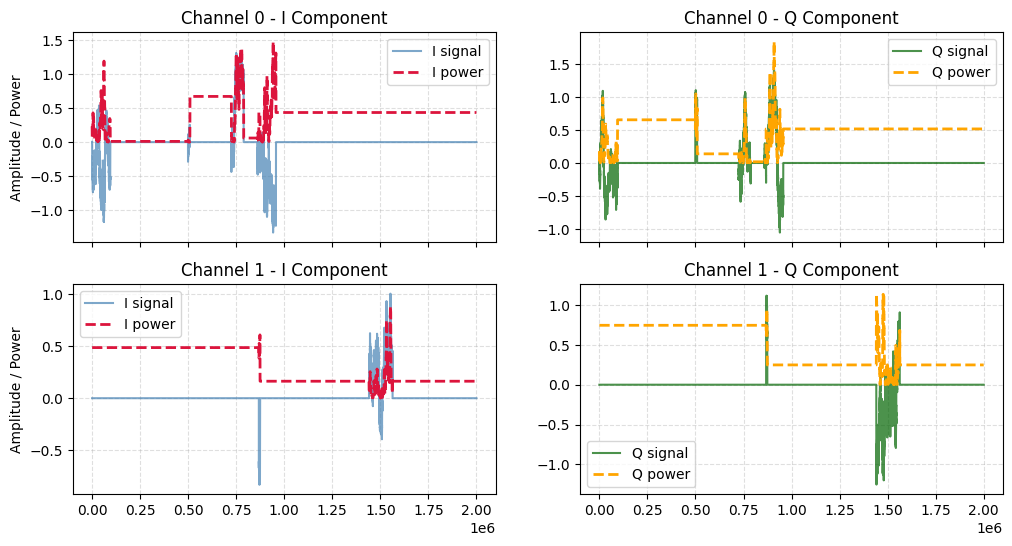

In [139]:
# plot_power_and_signals(output_samples_for_each_channel, result, num_channels)
plot_power_and_signals(output_samples_for_each_channel, result, 2)

In [ ]:
def finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples):
    sampleblock_length = int((0.5 / sample_time) // 10)

    power_per_channel = {}

    for i in range(num_channels):
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        Q_signal = np.array(output_samples_for_each_channel[i]['Q'])

        power_per_channel[i] = {}

        # Find nonzero stretches
        nonzero_mask = (I_signal != 0) | (Q_signal != 0)
        diff_mask = np.diff(nonzero_mask.astype(int))
        starts = np.where(diff_mask == 1)[0] + 1  # rising edges
        ends = np.where(diff_mask == -1)[0] + 1   # falling edges

        # Handle cases where nonzero starts at 0 or ends at total_samples
        if nonzero_mask[0]:
            starts = np.insert(starts, 0, 0)
        if nonzero_mask[-1]:
            ends = np.append(ends, total_samples)

        prev_end = 0  # track where the last stretch ended

        for s, e in zip(starts, ends):
            stretch_len = e - s
            n_blocks = int(np.ceil(stretch_len / sampleblock_length))

            block_powers = []

            # compute power for each block
            for b in range(n_blocks):
                start_idx = s + b * sampleblock_length
                end_idx = min(s + (b + 1) * sampleblock_length, e)

                I_block = I_signal[start_idx:end_idx]
                Q_block = Q_signal[start_idx:end_idx]

                block_power = np.mean(I_block**2 + Q_block**2)
                power_per_channel[i][start_idx] = block_power
                block_powers.append(block_power)

            # average power for this stretch
            avg_power = np.mean(block_powers)

            # fill zeros between previous stretch end and this stretch start
            if prev_end < s:
                for z in range(prev_end, s):
                    power_per_channel[i][z] = avg_power

            prev_end = e

        # fill remaining zeros after the last stretch
        if prev_end < total_samples:
            for z in range(prev_end, total_samples):
                power_per_channel[i][z] = avg_power if 'avg_power' in locals() else 0.0

    return power_per_channel

In [97]:
# def interpolate_smartly(data):
#     "The input data is of the form [index,value] we need to be able to diffrentiate between periodic and non periodic signals to do this we are just linearly interpolating in stft"
#     output_wifi_samples={}
#     for channel in data:
        
#         output_wifi_samples[channel]={'I':np.array([0 for i in range(2000000)]),'Q':np.array([0 for i in range(2000000)])}
#         I = np.zeros(2_000_000, dtype=np.float64)  # force float64
#         for cur_sample, val in data[channel]['I']:
#             idx = int(cur_sample)
#             I[idx] = float(val)
#         output_wifi_samples[channel]['I'] = I  # ensure the mutated array is stored

#         Q = np.zeros(2_000_000, dtype=np.float64)  # force float64
#         for cur_sample, val in data[channel]['Q']:
#             idx = int(cur_sample)
#             Q[idx] = float(val)
#         output_wifi_samples[channel]['Q'] = Q  # ensure the mutated array is stored

#     return output_wifi_samples


# Wifi_output_data_after_interpolation=interpolate_smartly(Wifi_output_samples)

# Per_channel_time_frequency_spectrum={}

# for channel in Wifi_symbols:
#     Per_channel_time_frequency_spectrum[channel]={}
#     I_f_t_spectrum=[]
#     Q_f_t_spectrum=[]
#     for i in range(num_fft-1):
#         #print((i+1)*num_samples_per_fft)
#         I_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation[channel]['I'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
#         Q_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation[channel]['Q'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
#     Per_channel_time_frequency_spectraum[channel]['I']=np.array(I_f_t_spectrum)
#     Per_channel_time_frequency_spectrum[channel]['Q']=np.array(Q_f_t_spectrum)



In [98]:
#plt.plot(Wifi_output_data_after_interpolation[1]['I'])
#print(Wifi_output_data_after_interpolation[1]['I'][0])

In [99]:
# fig,ax=plot_fft_rows_colormap_freq_on_y(Per_channel_time_frequency_spectrum[2]['I'])
# plt.show()

Doing Naive method

In [100]:
Wifi_naive_symbols={}
size_of_naive_samples_per_channel=100000

cur_num=0
for channel in Wifi_symbols:
    Wifi_naive_symbols[channel]={'I':[],'Q':[]}

while cur_num<total_samples:
    for channel in Wifi_symbols:
        for i in range(size_of_naive_samples_per_channel):
            Wifi_naive_symbols[channel]['I'].append((cur_num,Wifi_symbols[channel]['I'][cur_num]))
            Wifi_naive_symbols[channel]['Q'].append((cur_num,Wifi_symbols[channel]['Q'][cur_num]))
            cur_num+=1
        #cur_num+=size_of_naive_samples_per_channel
        if cur_num>=total_samples:
            break
#I = np.zeros(2_000_000, dtype=np.float64)  # force float64
print(Wifi_naive_symbols[1]['I'][:100])
#Wifi_naive_symbols[channel]['I'] = I  # ensure the mutated array is stored


NameError: name 'Wifi_symbols' is not defined

In [ ]:
Wifi_output_data_after_interpolation_naive=interpolate_smartly(Wifi_naive_symbols)

Per_channel_time_frequency_spectrum={}

for channel in Wifi_symbols:
    Per_channel_time_frequency_spectrum[channel]={}
    I_f_t_spectrum=[]
    Q_f_t_spectrum=[]
    for i in range(num_fft-1):
        #print((i+1)*num_samples_per_fft)
        I_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation_naive[channel]['I'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
        Q_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation_naive[channel]['Q'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
    Per_channel_time_frequency_spectrum[channel]['I']=np.array(I_f_t_spectrum)
    Per_channel_time_frequency_spectrum[channel]['Q']=np.array(Q_f_t_spectrum)


fig,ax=plot_fft_rows_colormap_freq_on_y(Per_channel_time_frequency_spectrum[2]['I'])
plt.show()